In [1]:
%matplotlib inline
%pylab inline
import pylab
pylab.rcParams['figure.figsize'] = (5.0, 5.0)
from tsne import bh_sne # thi is the correct tsne to use.  It's the one discussed btnw
from bhtsne import bh_tsne
import sklearn.manifold
from matplotlib import pyplot as plt
import pandas
import scipy
import numpy as np
import os
import gc
from time import gmtime, strftime
import seaborn as sns
from os import listdir
from os.path import isfile, join
import math
from scipy.stats.stats import pearsonr
import random as rand
from sklearn.preprocessing import normalize
from collections import defaultdict
import pickle
# from helpers import *
execfile( "./helpers.py")


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib
helpers executed


### load all the data at 200m

In [2]:

def get_where_img0_is_1(pddf):
    img0_metadata = (META.loc[META['img0'] == 1])
    return pddf.loc[pddf['hcad'].isin(list(img0_metadata['hcad']))]
TERRAIN = load_dataset("/home/isaac/Dropbox/data_for_brian/terrain_features/dsmgrid/terrain_200.hd")

hcad_data = [
    load_dataset("/home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_100.hd", include_hcad= False),
     load_dataset("/home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_200.hd", include_hcad= False),
     load_dataset("/home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_400.hd", include_hcad= False),
    load_dataset("/home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_1000.hd", include_hcad= False)
]

hcad = load_dataset("/home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_200.hd")
# hcad = hcad[['hcad', 'mean_accrued_depr_pct', 'mean_bld_val', 'mean_land_val','mean_quality','mean_rcnld', 'mean_tot_mkt_val','mean_year_built','mean_year_remodeled']]
META = load_dataset("/home/isaac/Dropbox/data_for_brian/meta/df_meta.hd")
WIND = load_dataset("/home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad200_hist16x16.mat.hd")

Y_DATA = load_dataset("/home/isaac/Dropbox/data_for_brian/y_df.hd", scale = False)



# @memo
img0_y_data = get_where_img0_is_1(Y_DATA)
img0_terrain_data = get_where_img0_is_1(TERRAIN)
img0_wind_data = get_where_img0_is_1(WIND)
img0_hcad_data = get_where_img0_is_1(hcad)
img0_metadata = (META.loc[META['img0'] == 1])
# print get_where_img0_is_1(WIND)
def plot_on_map(pddf, meta = META):
    for col in pddf.columns:
        print("\n\n\n",col)
        xy = pandas.DataFrame.from_dict({'x': -meta['pointx'],'y': meta['pointy']})
        print("linear plot")
        fast_show_ratio_plot(xy,np.array(pddf[col]))
        print("log plot")
        fast_show_ratio_plot(xy,np.array(pddf[col]), log = True)
        colored_scatter(xy,np.array(pddf[col]))

Opening /home/isaac/Dropbox/data_for_brian/terrain_features/dsmgrid/terrain_200.hd in read-only mode


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

Opening /home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_100.hd in read-only mode


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

Opening /home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_200.hd in read-only mode


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

Opening /home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_400.hd in read-only mode


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

Opening /home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_1000.hd in read-only mode


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

Opening /home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_200.hd in read-only mode


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

Opening /home/isaac/Dropbox/data_for_brian/meta/df_meta.hd in read-only mode


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

Opening /home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad200_hist16x16.mat.hd in read-only mode


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

Opening /home/isaac/Dropbox/data_for_brian/y_df.hd in read-only mode


### make an embedding

In [48]:

# print img0_hcad_data.shape

# np.savetxt('y.csv', img0_y_data, delimiter=',') 

embedding_2d = fast_tsne(img0_hcad_data, embedded_dimensions=2)



In [59]:
pickle.dump(embedding_2d, open( "img0_hcad_data_2d_embed.p", "wb" ))

[[   9.09896396   10.48251672    9.31655884   10.95815071    3.78714682]
 [-796.02451861    9.08407422   10.94314419    9.51374275   10.69874208]
 [   9.69976613   10.89266217    9.51430084   10.69882968    9.50400789]
 ..., 
 [  50.99869134   24.04653787   -6.69333412   -6.77382818   -6.66622111]
 [   8.83868819 -191.56343468   -6.69315469   -6.77386007   -6.66603728]
 [ 114.50421105 -448.05556133   -6.69318709   -6.77371208   -6.66634776]]


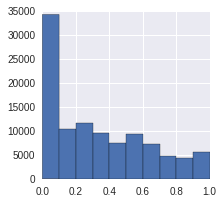

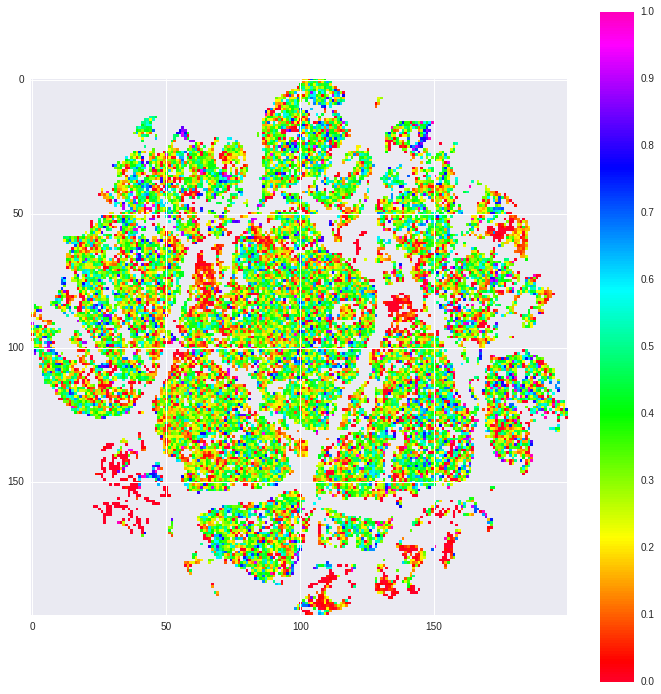

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [52]:
print(embedding_5d)
old_fast_show_ratio_plot(pandas.DataFrame.from_dict({'x': embedding_2d[:,0],
                                             'y': embedding_2d[:,1]}), np.array(img0_y_data['y200_mean'])[:])

### kmeans cluster the data

In [20]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
kmeans = KMeans(init='k-means++', n_clusters=30)
kmeans.fit(embedding_2d)
print kmeans.labels_

# np.random.shuffle(kmeans.labels_)
colored_scatter(pandas.DataFrame.from_dict({'x': - img0_metadata ['pointx'][:len(kmeans.labels_)],
                                            'y': img0_metadata['pointy'][:len(kmeans.labels_)]}), kmeans.labels_)
fast_show_ratio_plot(pandas.DataFrame.from_dict({'x': - img0_metadata ['pointx'][:len(kmeans.labels_)],
                                                 'y': img0_metadata['pointy'][:len(kmeans.labels_)]}),kmeans.labels_)

for label in range(max(kmeans.labels_)+1):
    print "class", label, "damage:",np.mean(np.array(img0_y_data['y200_mean'])[numpy.where(kmeans.labels_==label)])

NameError: name 'embedding_2d' is not defined

In [ ]:
print pandas.read_pickle("/home/isaac/Desktop/devika/gitignored/testing_refactored_code/_mean_accrued_depr_pct_std_accrued_depr_p_n:100")

In [ ]:
# print np.array(tsne_embed['x'])[0]
# show_ratio_plot(tsne_embed, hcad['mean_bld_val'])
# print get_meta()
# print Y_DATA

plot_on_map(img0_hcad_data, meta = img0_metadata)

 ### CNN

In [ ]:

# ############################# Batch iterator ###############################
# This is just a simple helper function iterating over training data in
# mini-batches of a particular size, optionally in random order. It assumes
# data is available as numpy arrays. For big datasets, you could load numpy
# arrays as memory-mapped files (np.load(..., mmap_mode='r')), or write your
# own custom data iteration function. For small datasets, you can also copy
# them to GPU at once for slightly improved performance. This would involve
# several changes in the main program, though, and is not demonstrated here.

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
print("Loading data...")
X_train, y_train, X_val, y_val, X_test, y_test = load_mega_hcad()

# use this to show that the network trains on simple identity data
# for i, _ in enumerate(X_train):
#     X_train[i].fill(y_train[i])


Loading data...
('hcad length', (702356, 285))
('y_data length', (702356, 10))


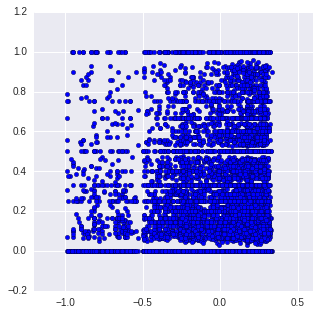

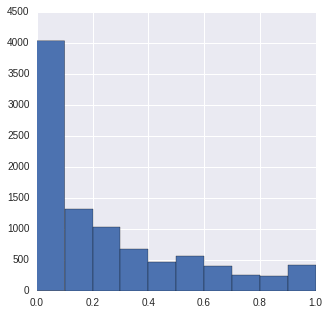

In [64]:
# print(X_train)
plt.scatter(X_train[:,0,3,0], y_train)
plt.show()
plt.hist(y_train)
plt.show()

Using gpu device 0: GeForce GTX 970 (CNMeM is disabled)


[ 0.          0.5         0.22222222 ...,  0.75        0.          0.        ]
(9364,)
train max 1.0
x train shape (9364, 1, 285, 1)
Building model and compiling functions...
Starting training...


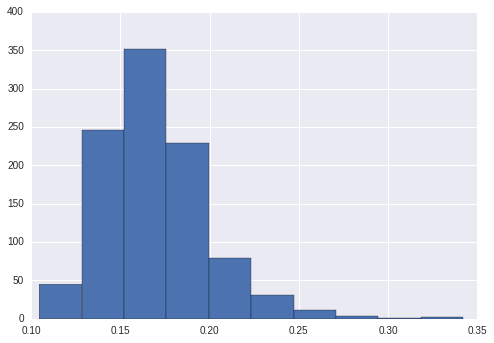

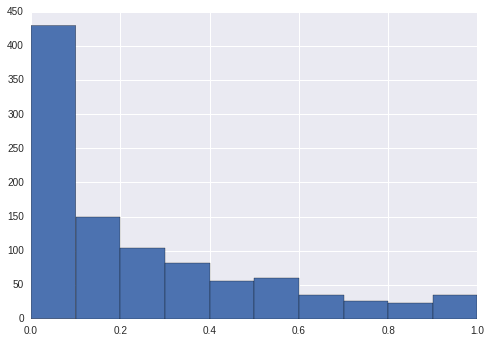

Epoch 1 of 500 took 0.464s
  training loss:		0.315404
  training loss without regularization:		0.259261
  validation loss:		0.051590
  validation accuracy:		96.74 %


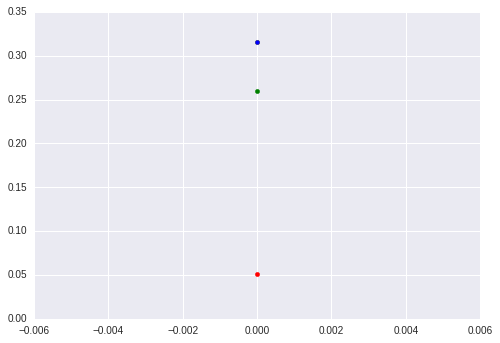

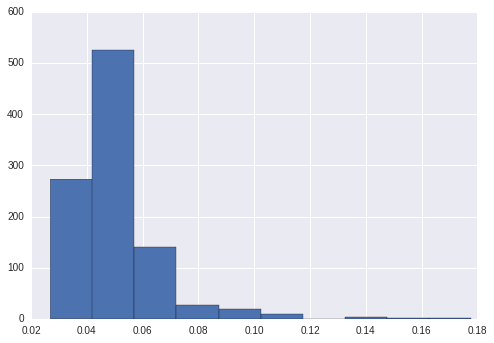

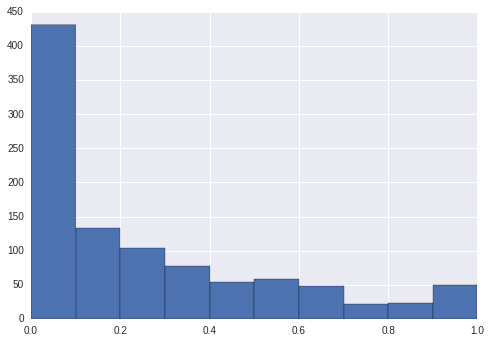

Epoch 2 of 500 took 0.435s
  training loss:		0.092852
  training loss without regularization:		0.036702
  validation loss:		0.032082
  validation accuracy:		96.74 %


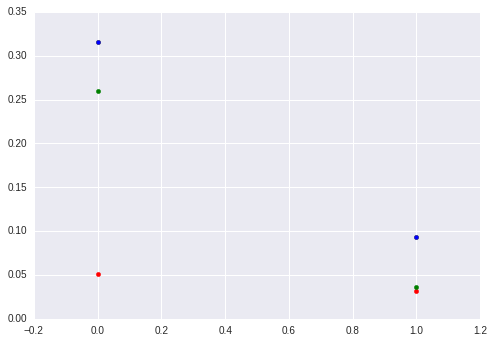

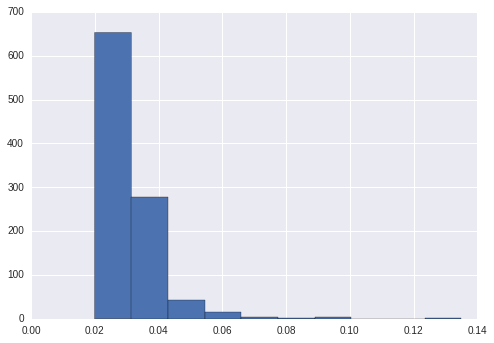

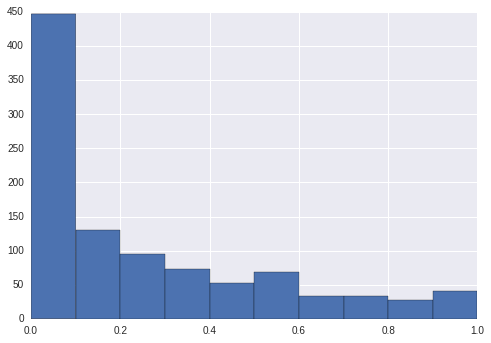

Epoch 3 of 500 took 0.503s
  training loss:		0.086681
  training loss without regularization:		0.030522
  validation loss:		0.031630
  validation accuracy:		96.74 %


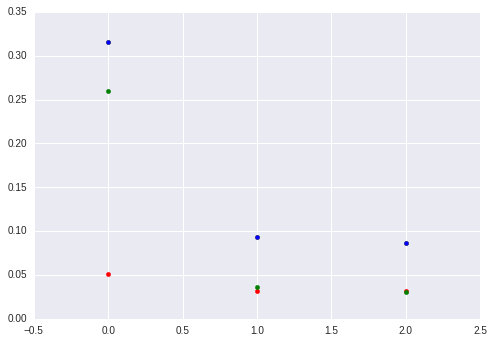

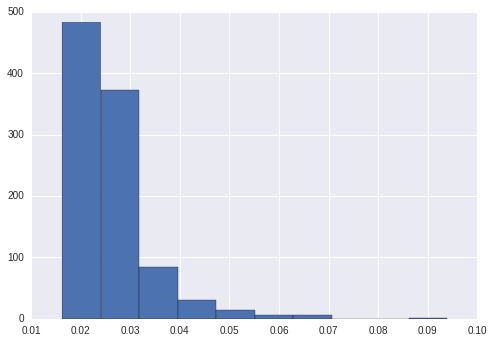

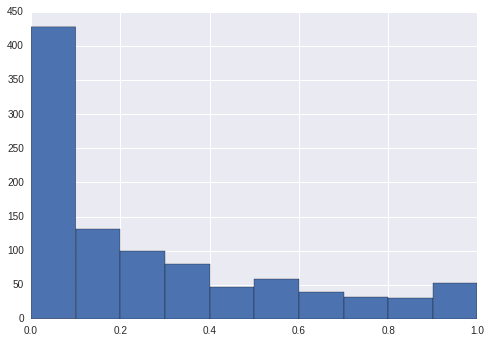

Epoch 4 of 500 took 0.426s
  training loss:		0.086424
  training loss without regularization:		0.030272
  validation loss:		0.031645
  validation accuracy:		96.75 %


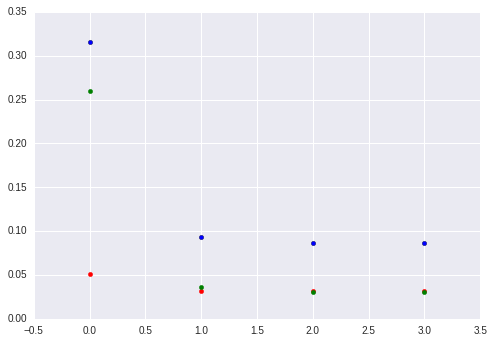

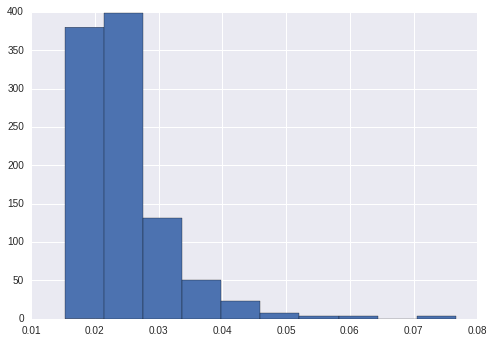

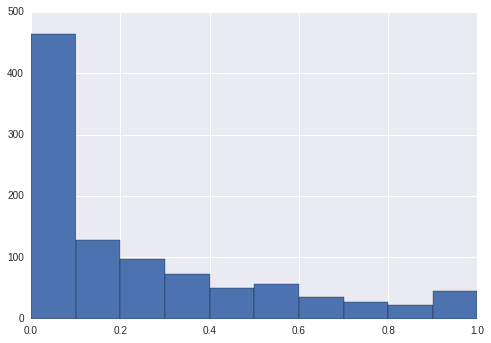

Epoch 5 of 500 took 0.417s
  training loss:		0.086420
  training loss without regularization:		0.030282
  validation loss:		0.031694
  validation accuracy:		96.74 %


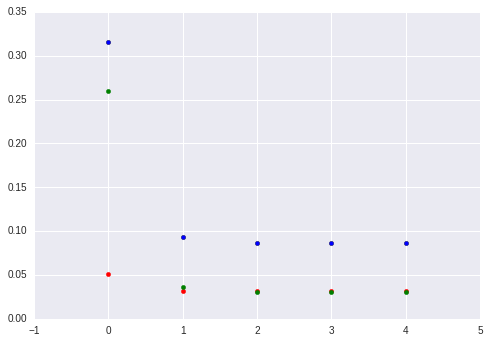

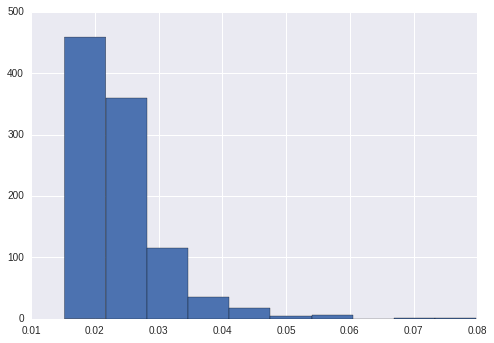

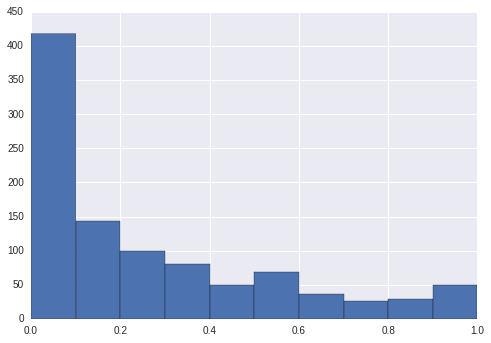

Epoch 6 of 500 took 0.425s
  training loss:		0.086200
  training loss without regularization:		0.030079
  validation loss:		0.031663
  validation accuracy:		96.75 %


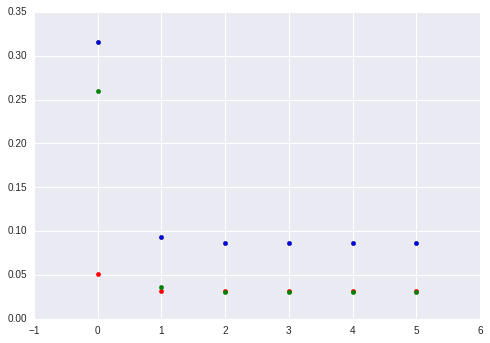

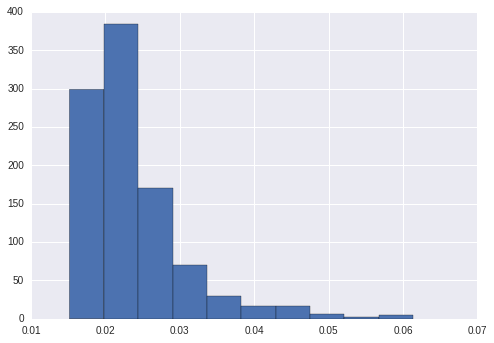

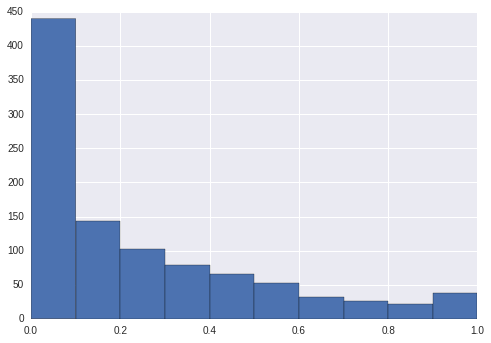

Epoch 7 of 500 took 0.433s
  training loss:		0.085856
  training loss without regularization:		0.029755
  validation loss:		0.031722
  validation accuracy:		96.74 %


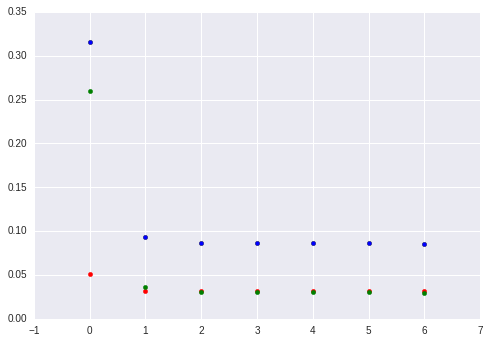

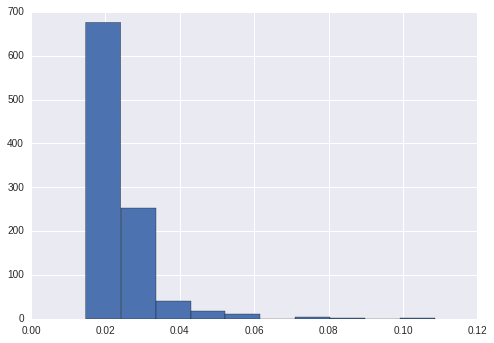

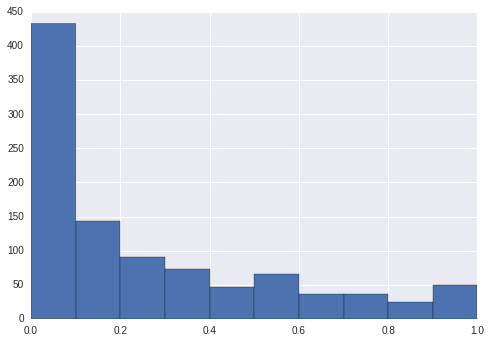

Epoch 8 of 500 took 0.419s
  training loss:		0.086479
  training loss without regularization:		0.030398
  validation loss:		0.031687
  validation accuracy:		96.74 %


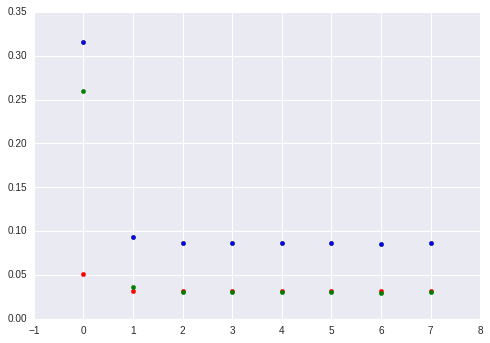

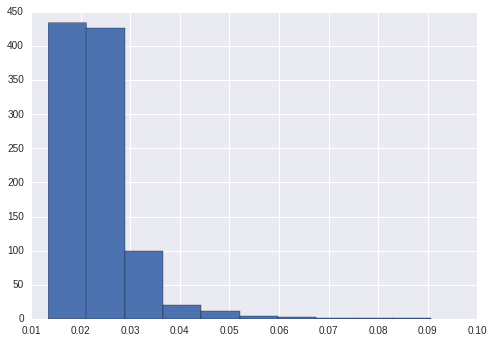

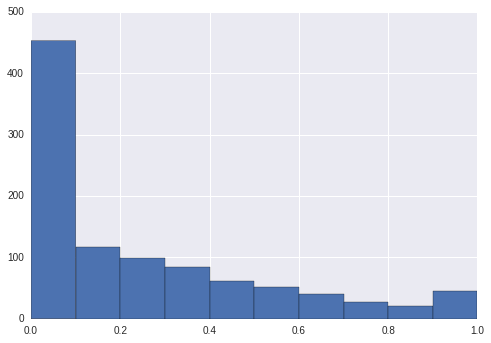

Epoch 9 of 500 took 0.435s
  training loss:		0.086662
  training loss without regularization:		0.030602
  validation loss:		0.031701
  validation accuracy:		96.74 %


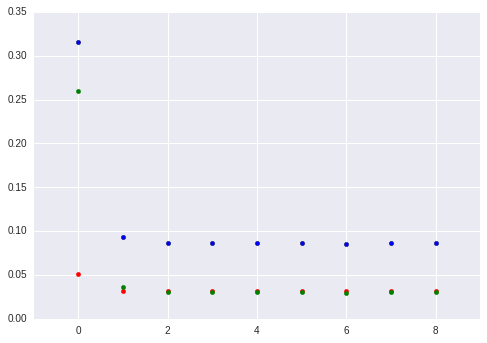

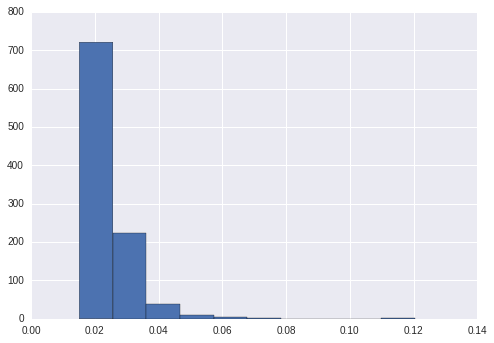

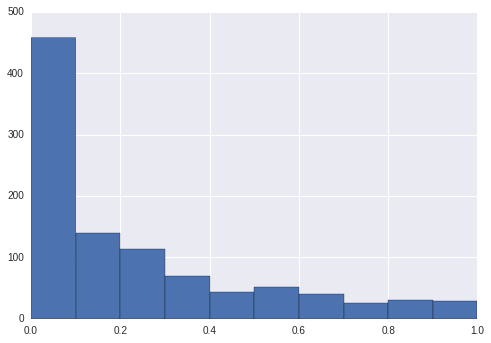

Epoch 10 of 500 took 0.485s
  training loss:		0.085695
  training loss without regularization:		0.029655
  validation loss:		0.031680
  validation accuracy:		96.74 %


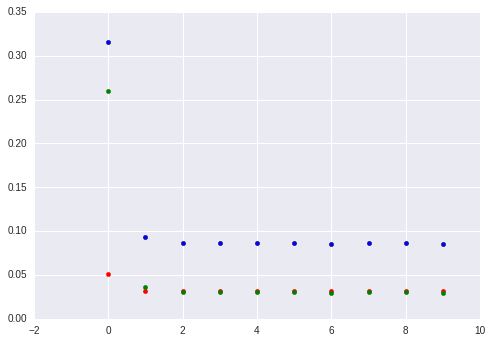

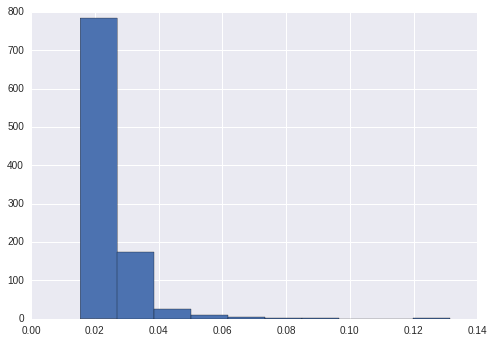

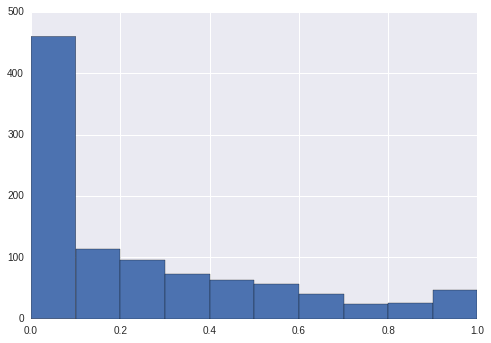

Epoch 11 of 500 took 0.416s
  training loss:		0.086728
  training loss without regularization:		0.030708
  validation loss:		0.031693
  validation accuracy:		96.74 %


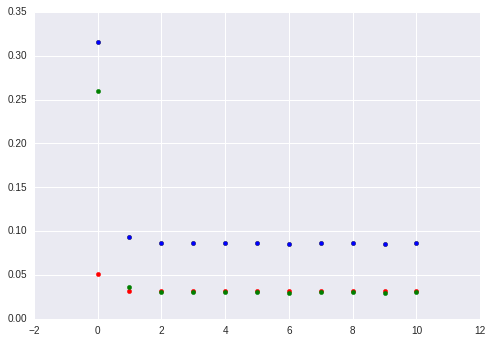

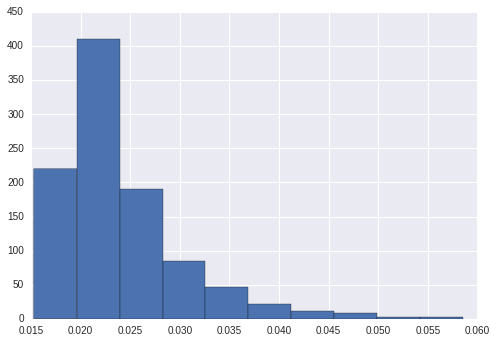

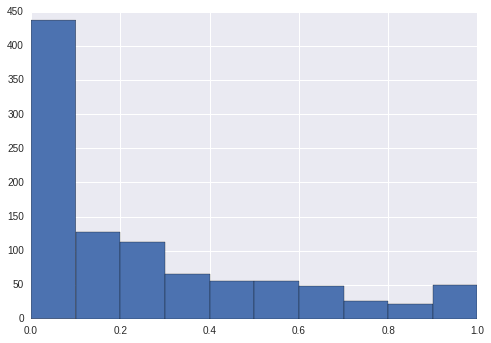

Epoch 12 of 500 took 0.432s
  training loss:		0.086074
  training loss without regularization:		0.030075
  validation loss:		0.031672
  validation accuracy:		96.74 %


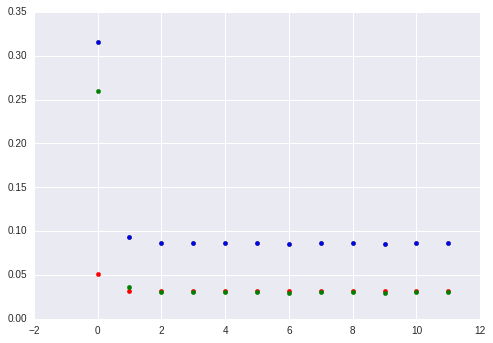

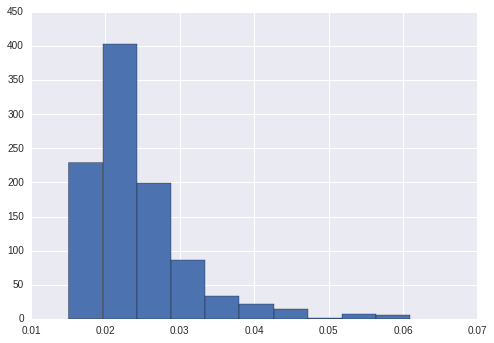

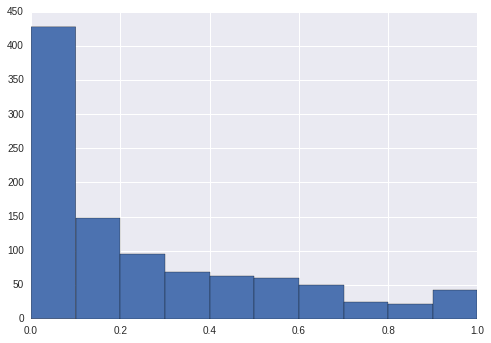

Epoch 13 of 500 took 0.458s
  training loss:		0.085635
  training loss without regularization:		0.029656
  validation loss:		0.031676
  validation accuracy:		96.74 %


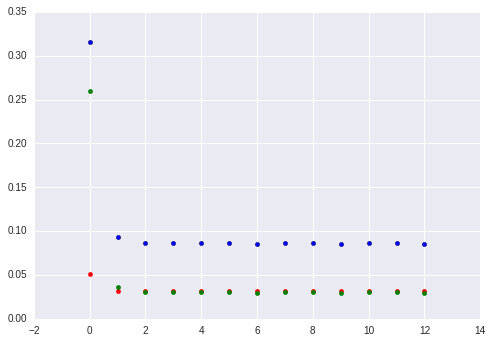

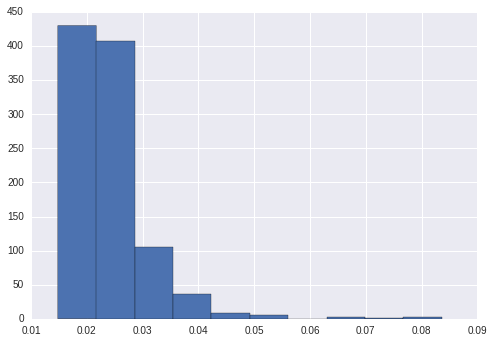

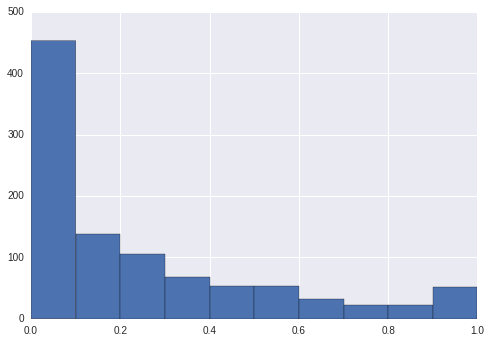

Epoch 14 of 500 took 0.517s
  training loss:		0.086662
  training loss without regularization:		0.030703
  validation loss:		0.031655
  validation accuracy:		96.75 %


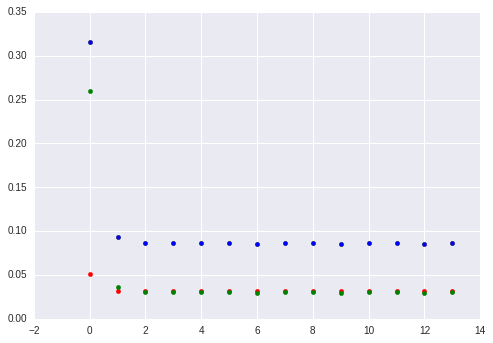

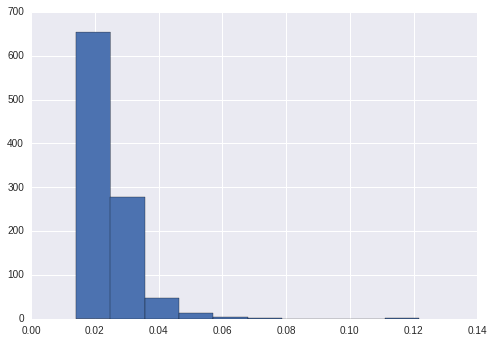

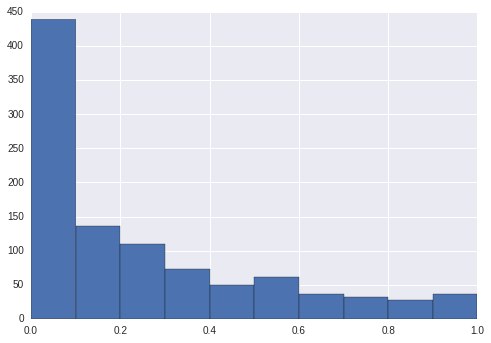

Epoch 15 of 500 took 0.530s
  training loss:		0.086422
  training loss without regularization:		0.030485
  validation loss:		0.031672
  validation accuracy:		96.74 %


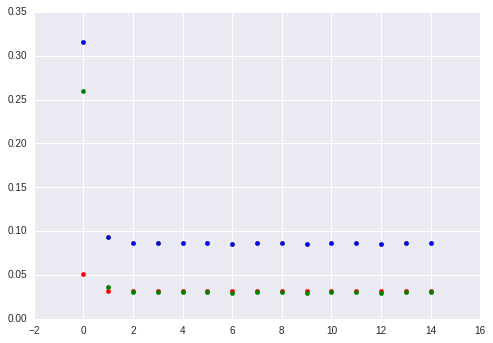

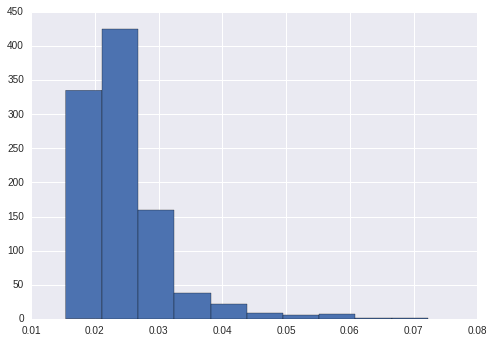

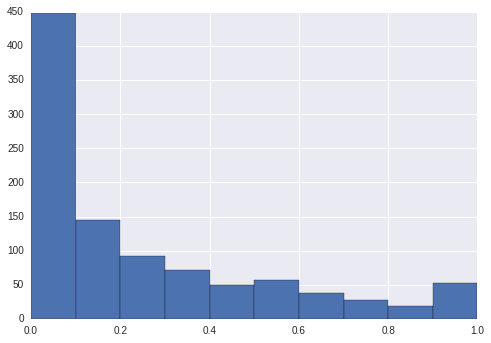

Epoch 16 of 500 took 0.437s
  training loss:		0.085985
  training loss without regularization:		0.030068
  validation loss:		0.031657
  validation accuracy:		96.74 %


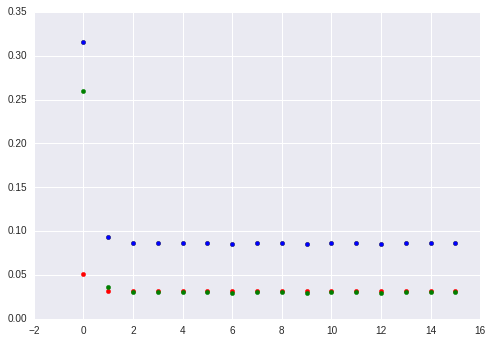

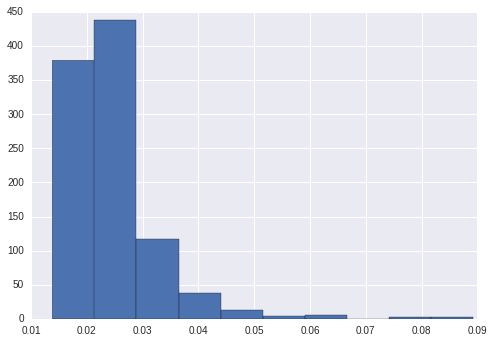

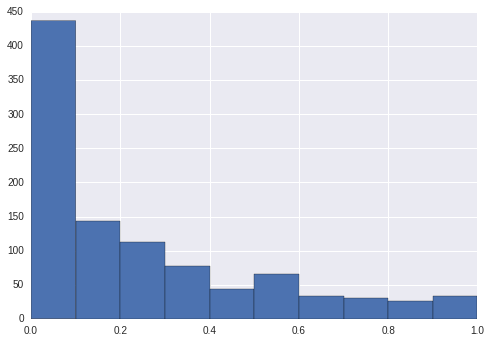

Epoch 17 of 500 took 0.454s
  training loss:		0.085644
  training loss without regularization:		0.029748
  validation loss:		0.031646
  validation accuracy:		96.75 %


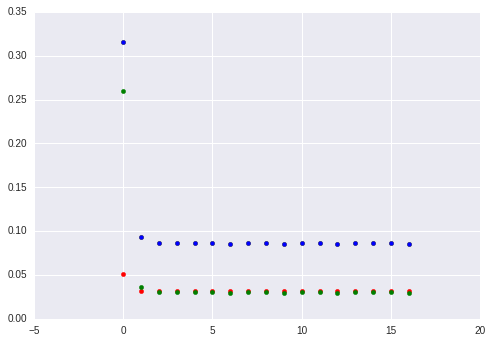

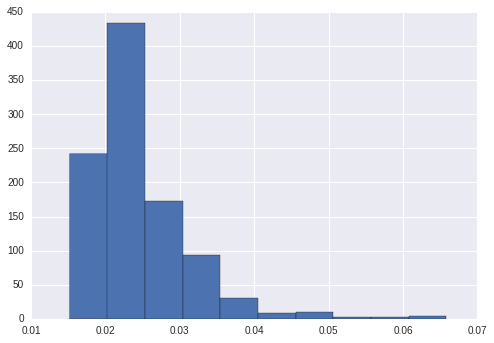

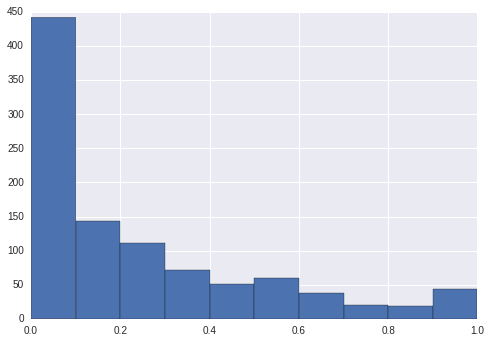

Epoch 18 of 500 took 0.429s
  training loss:		0.085731
  training loss without regularization:		0.029854
  validation loss:		0.031649
  validation accuracy:		96.75 %


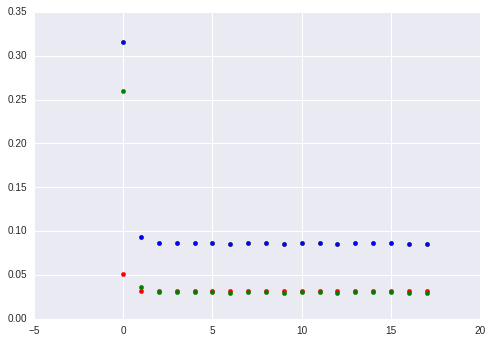

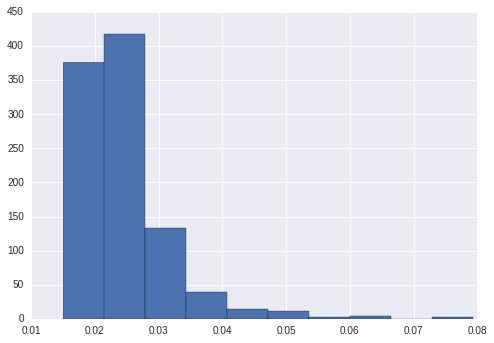

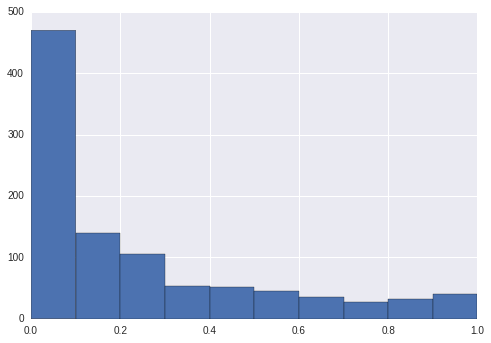

Epoch 19 of 500 took 0.422s
  training loss:		0.086450
  training loss without regularization:		0.030594
  validation loss:		0.031653
  validation accuracy:		96.75 %


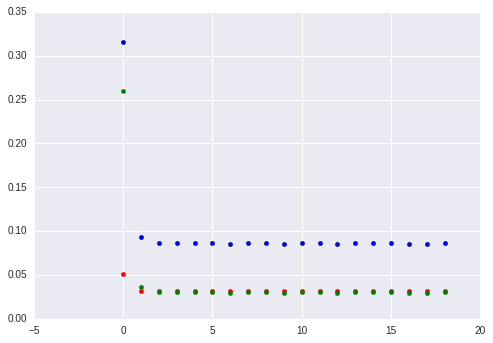

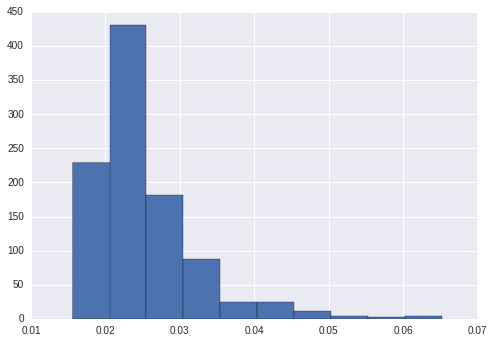

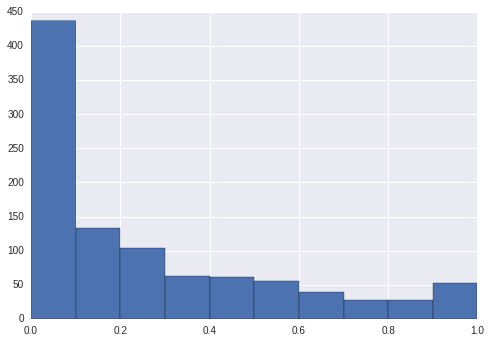

Epoch 20 of 500 took 0.476s
  training loss:		0.086007
  training loss without regularization:		0.030171
  validation loss:		0.031666
  validation accuracy:		96.74 %


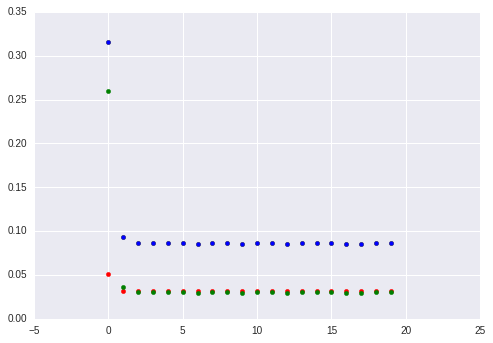

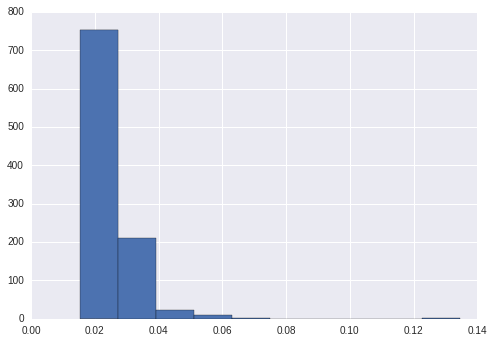

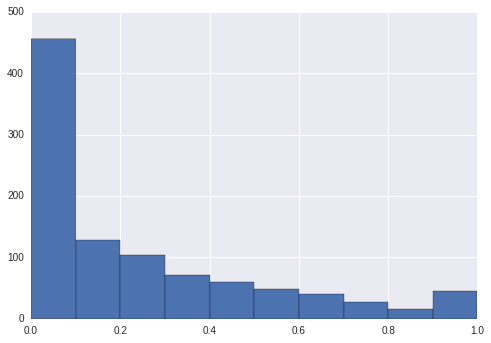

Epoch 21 of 500 took 0.554s
  training loss:		0.086193
  training loss without regularization:		0.030378
  validation loss:		0.031635
  validation accuracy:		96.75 %


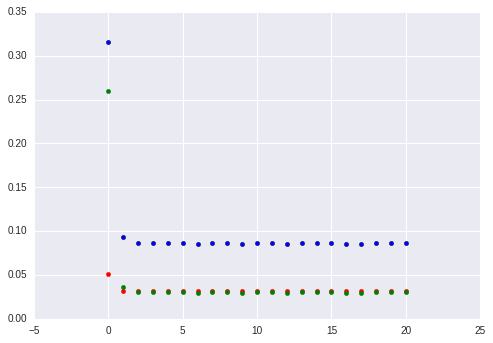

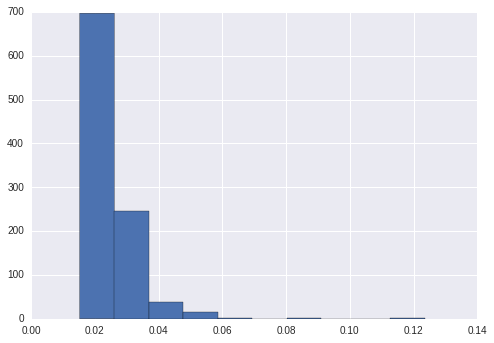

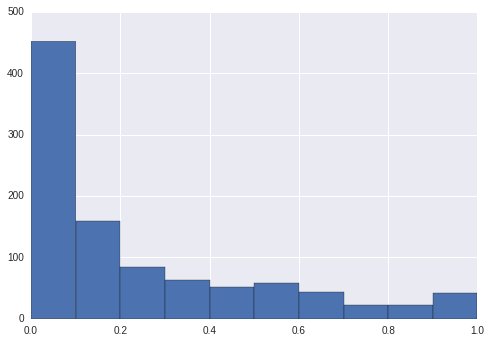

Epoch 22 of 500 took 0.457s
  training loss:		0.085961
  training loss without regularization:		0.030166
  validation loss:		0.031649
  validation accuracy:		96.75 %


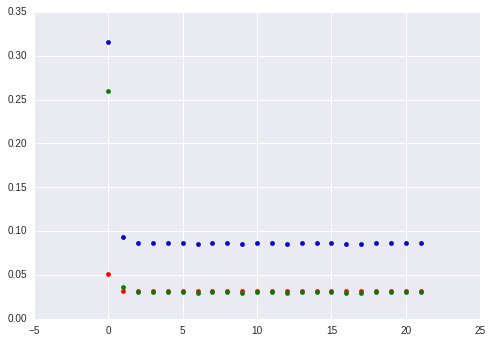

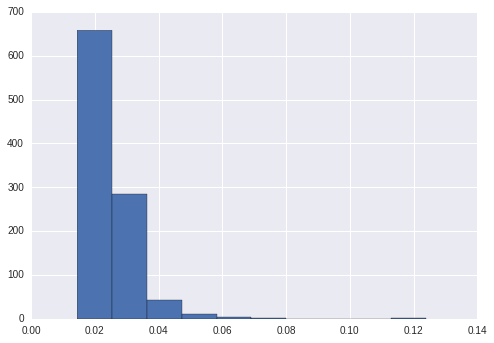

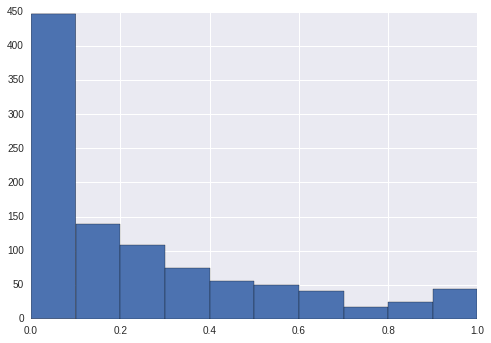

Epoch 23 of 500 took 0.429s
  training loss:		0.085939
  training loss without regularization:		0.030164
  validation loss:		0.031638
  validation accuracy:		96.75 %


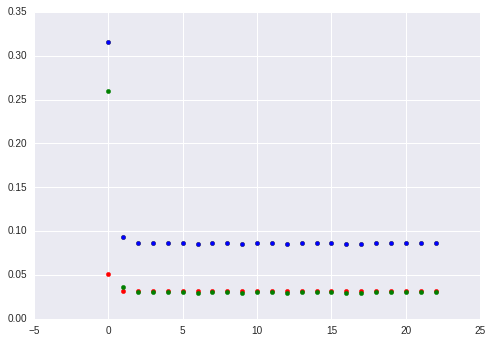

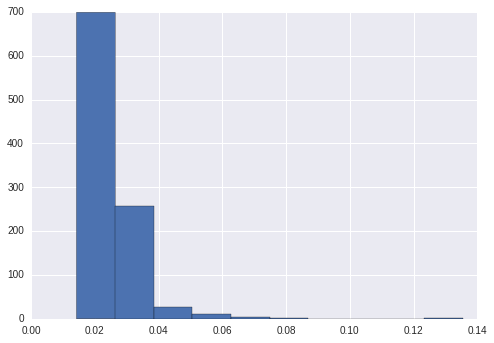

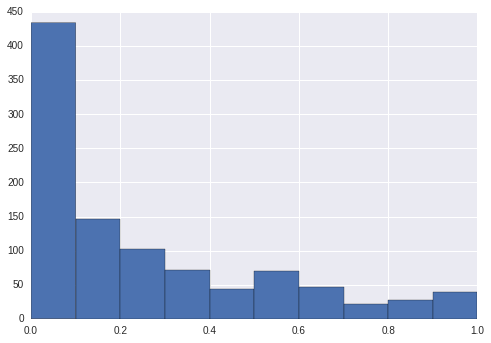

Epoch 24 of 500 took 0.425s
  training loss:		0.085598
  training loss without regularization:		0.029844
  validation loss:		0.031662
  validation accuracy:		96.74 %


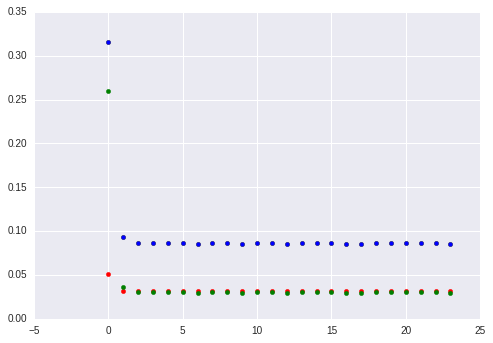

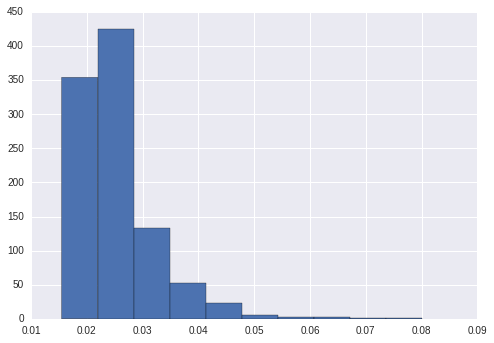

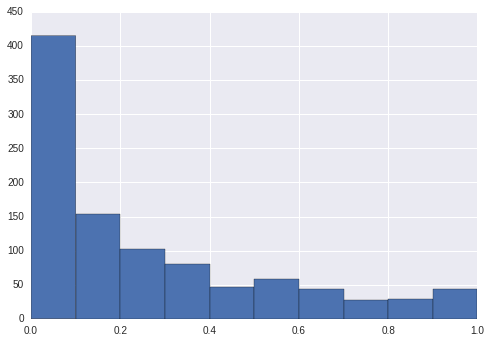

Epoch 25 of 500 took 0.505s
  training loss:		0.086323
  training loss without regularization:		0.030589
  validation loss:		0.031674
  validation accuracy:		96.74 %


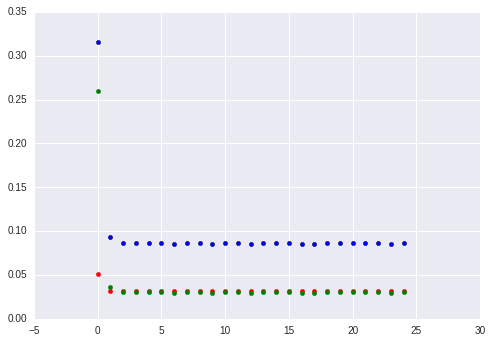

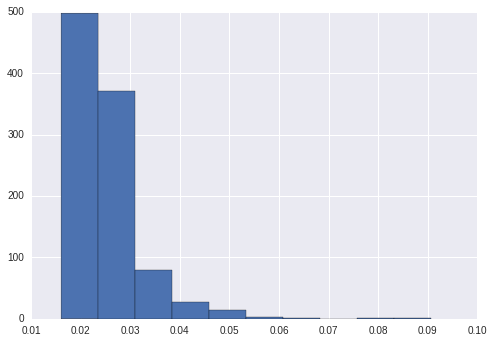

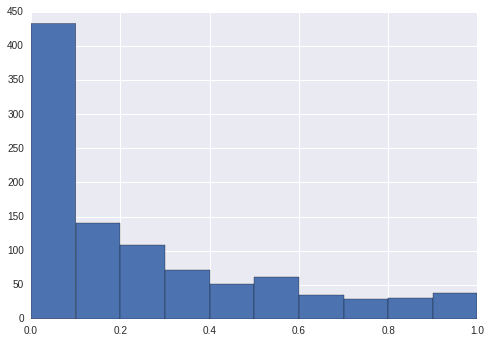

Epoch 26 of 500 took 0.465s
  training loss:		0.086186
  training loss without regularization:		0.030472
  validation loss:		0.031650
  validation accuracy:		96.74 %


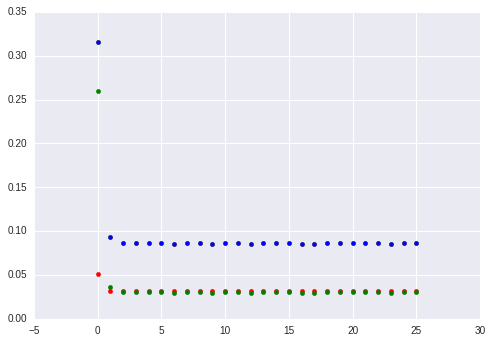

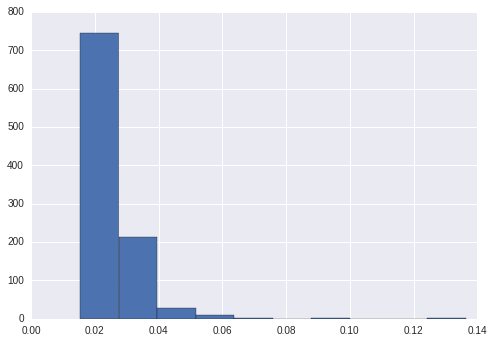

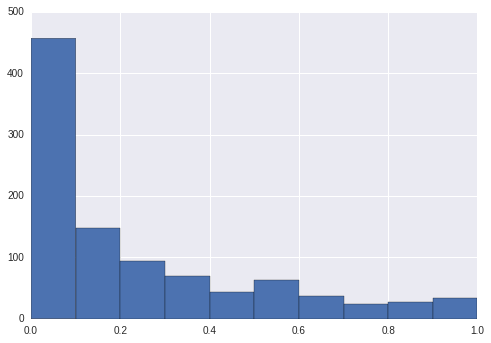

Epoch 27 of 500 took 0.427s
  training loss:		0.085862
  training loss without regularization:		0.030168
  validation loss:		0.031663
  validation accuracy:		96.74 %


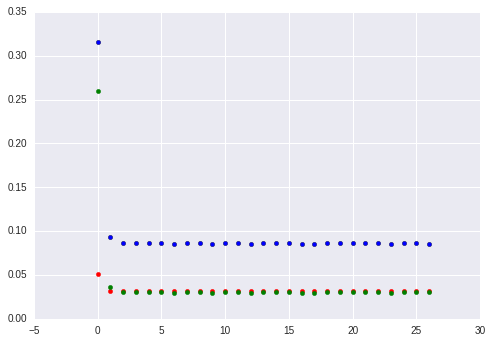

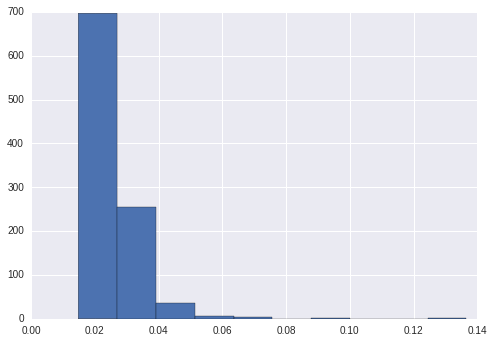

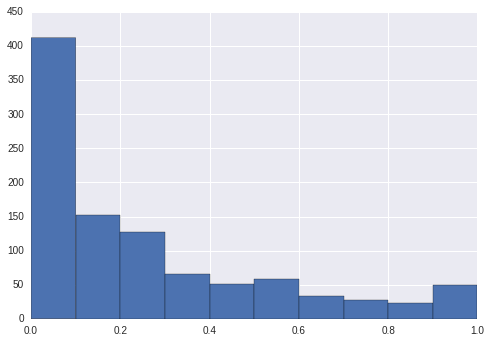

Epoch 28 of 500 took 0.422s
  training loss:		0.085628
  training loss without regularization:		0.029955
  validation loss:		0.031671
  validation accuracy:		96.74 %


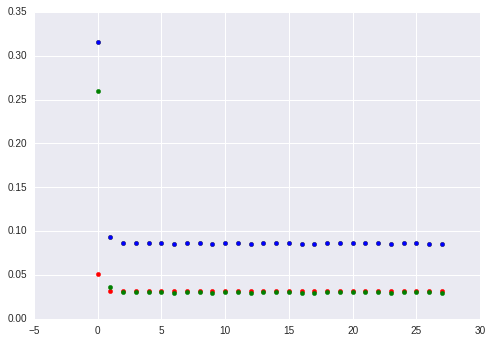

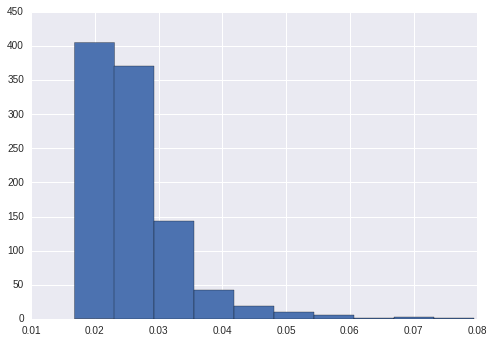

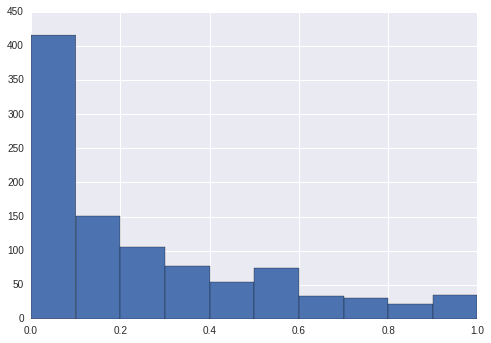

Epoch 29 of 500 took 0.430s
  training loss:		0.085923
  training loss without regularization:		0.030270
  validation loss:		0.031689
  validation accuracy:		96.74 %


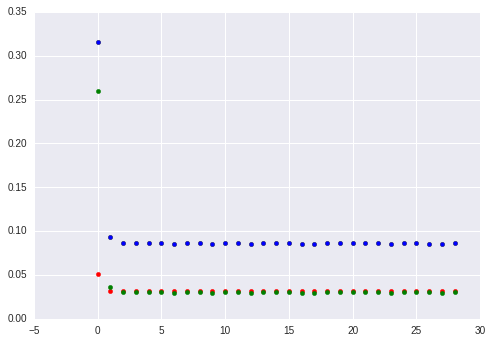

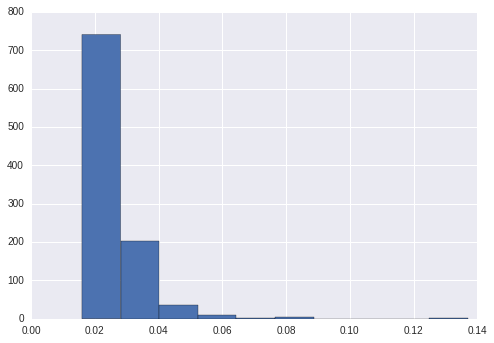

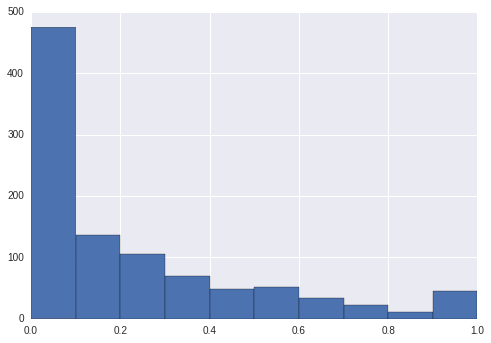

Epoch 30 of 500 took 0.442s
  training loss:		0.085581
  training loss without regularization:		0.029948
  validation loss:		0.031626
  validation accuracy:		96.75 %


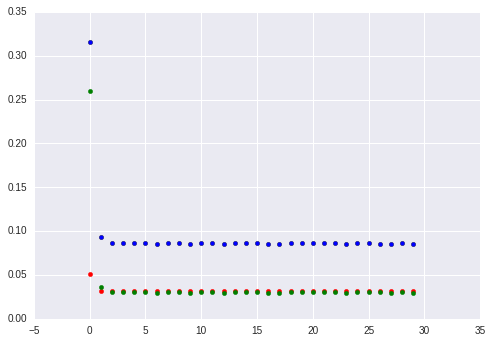

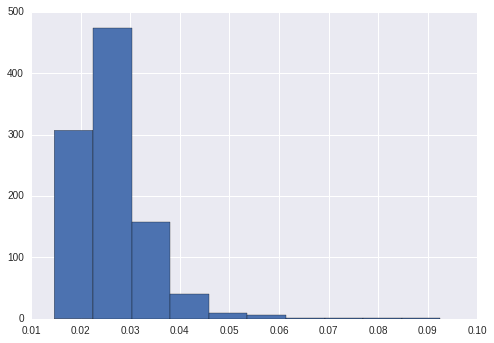

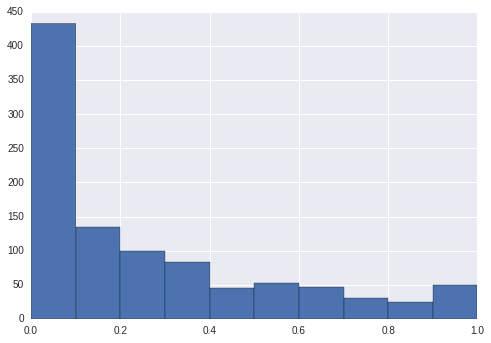

Epoch 31 of 500 took 0.458s
  training loss:		0.086088
  training loss without regularization:		0.030476
  validation loss:		0.031673
  validation accuracy:		96.74 %


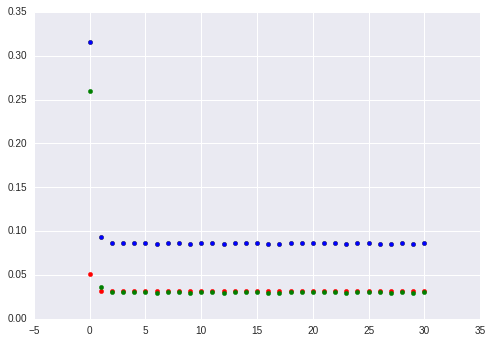

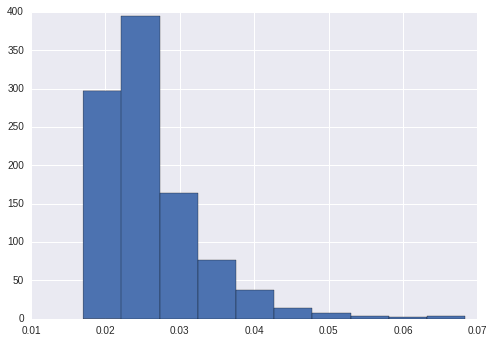

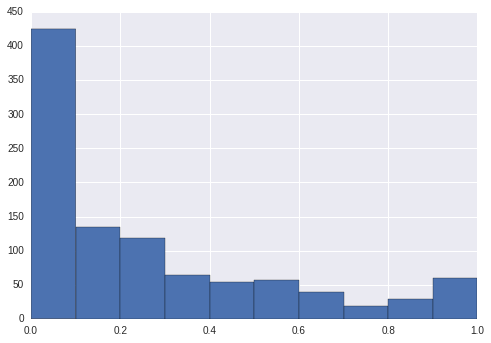

Epoch 32 of 500 took 0.511s
  training loss:		0.085544
  training loss without regularization:		0.029951
  validation loss:		0.031668
  validation accuracy:		96.74 %


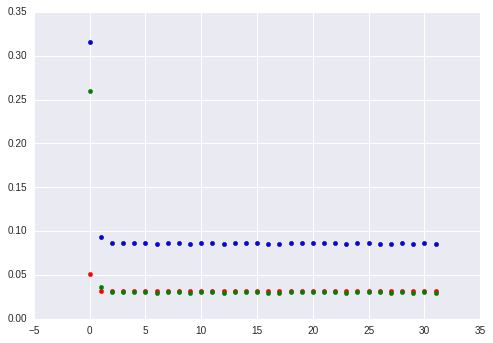

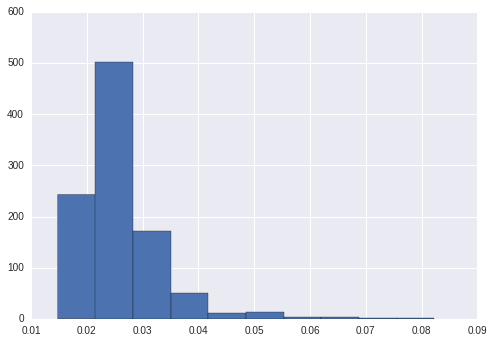

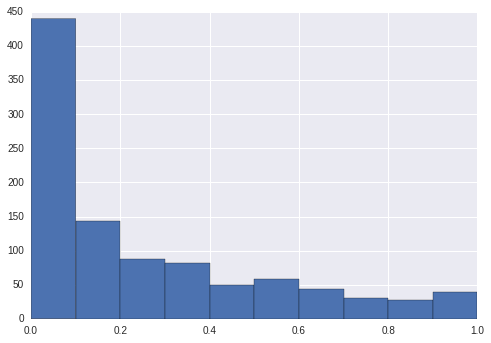

Epoch 33 of 500 took 0.429s
  training loss:		0.086049
  training loss without regularization:		0.030477
  validation loss:		0.031643
  validation accuracy:		96.74 %


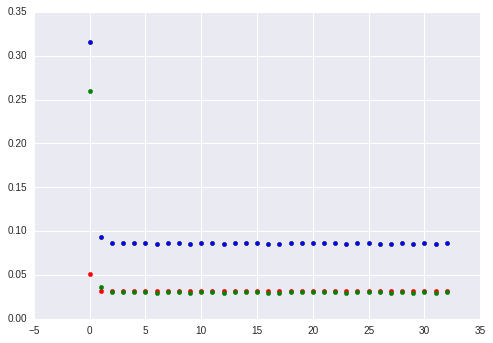

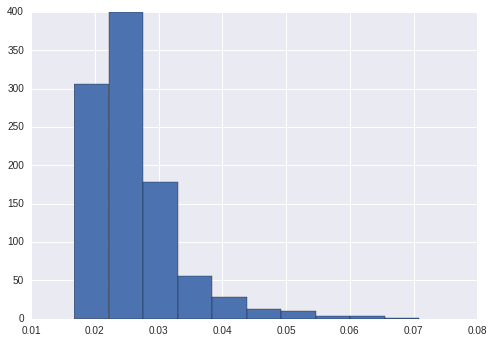

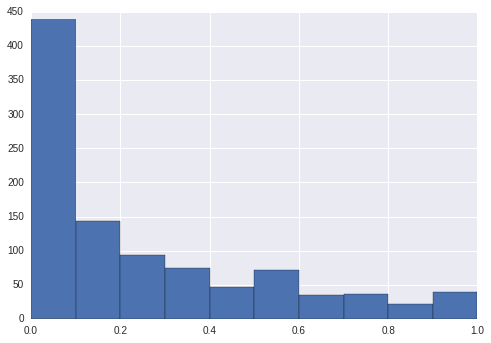

Epoch 34 of 500 took 0.428s
  training loss:		0.086343
  training loss without regularization:		0.030792
  validation loss:		0.031628
  validation accuracy:		96.75 %


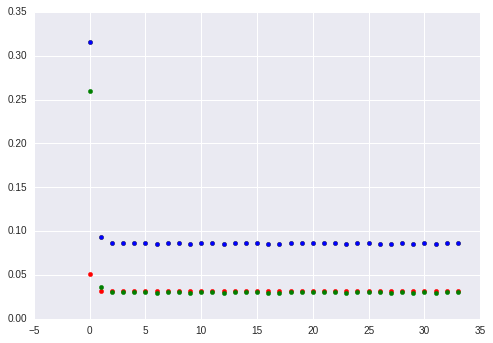

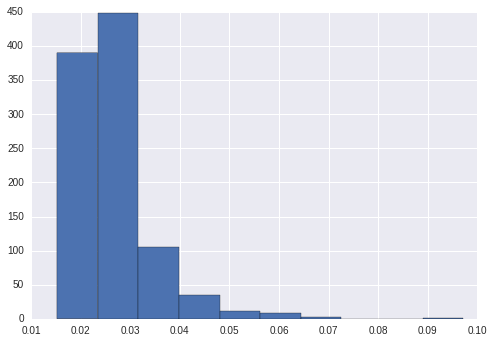

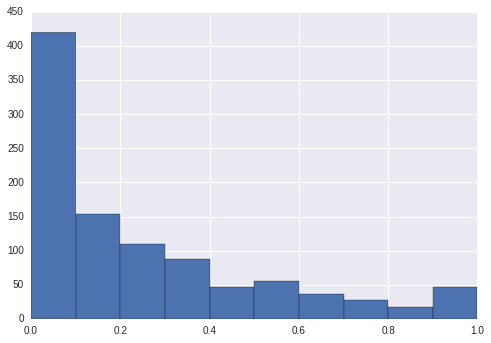

Epoch 35 of 500 took 0.433s
  training loss:		0.085893
  training loss without regularization:		0.030362
  validation loss:		0.031670
  validation accuracy:		96.74 %


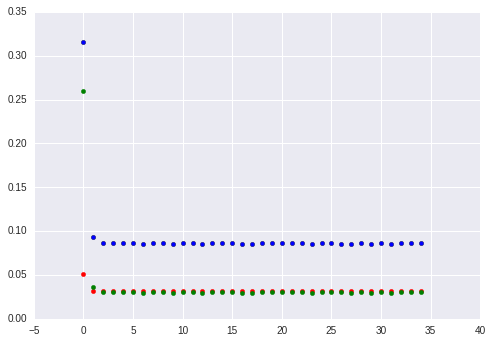

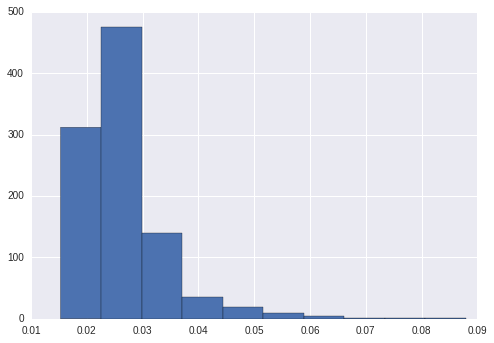

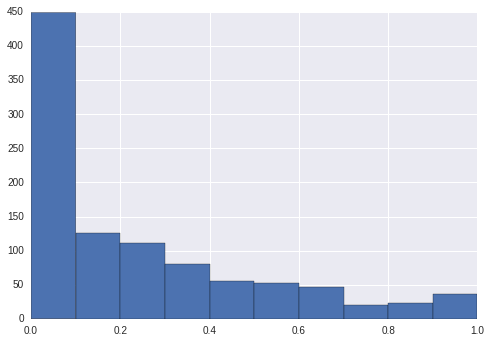

Epoch 36 of 500 took 0.497s
  training loss:		0.085770
  training loss without regularization:		0.030259
  validation loss:		0.031669
  validation accuracy:		96.74 %


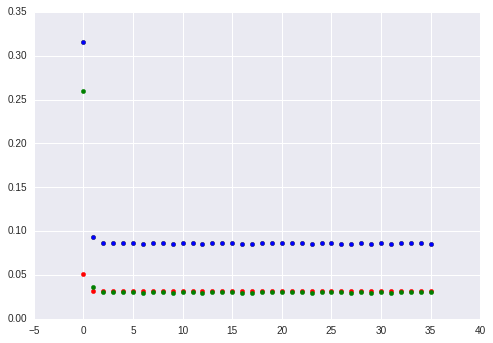

In [ ]:
from __future__ import print_function

import sys
import os
import time

import numpy as np
import theano
import theano.tensor as T

import lasagne
from lasagne.regularization import regularize_layer_params_weighted
from lasagne.init import Constant, GlorotUniform



def build_cnn(input_var=None):
    # As a third model, we'll create a CNN of two convolution + pooling stages
    # and a fully-connected hidden layer in front of the output layer.

    # Input layer, as usual:
    network = lasagne.layers.InputLayer(shape=(None, 1, X_train.shape[2], 1),
                                        input_var=input_var)
    
    #####make a single dense layer
    network = lasagne.layers.DenseLayer(
            network,
            #lasagne.layers.dropout(network, p=.5),
            num_units=30,
            nonlinearity=lasagne.nonlinearities.rectify)
    
    
    network = lasagne.layers.DenseLayer(
            network,
            #lasagne.layers.dropout(network, p=.5),
            num_units=1,
            nonlinearity=lasagne.nonlinearities.sigmoid)

    return network
    
    # This time we do not apply input dropout, as it tends to work less well
    # for convolutional layers.

    # Convolutional layer with 32 kernels of size 5x5. Strided and padded
    # convolutions are supported as well; see the docstring.
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=32, filter_size=(5, 1),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=GlorotUniform('relu'), b=Constant(0.0))
    # Expert note: Lasagne provides alternative convolutional layers that
    # override Theano's choice of which implementation to use; for details
    # please see http://lasagne.readthedocs.org/en/latest/user/tutorial.html.

    # Max-pooling layer of factor 2 in both dimensions:
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 1))

    # Another convolution with 32 5x5 kernels, and another 2x2 pooling:
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=32, filter_size=(5, 1),
            nonlinearity=lasagne.nonlinearities.rectify)
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 1))

    # A fully-connected layer of 256 units with 50% dropout on its inputs:
#     network = lasagne.layers.DenseLayer(
#             lasagne.layers.dropout(network, p=.5),
#             num_units=256,
#             nonlinearity=lasagne.nonlinearities.rectify)

    # And, finally, the 10-unit output layer with 50% dropout on its inputs:
    network = lasagne.layers.DenseLayer(
            network,
            #lasagne.layers.dropout(network, p=.5),
            num_units=1,
            nonlinearity=lasagne.nonlinearities.rectify)

    return network


def main(model='mlp', num_epochs=500):
    training_losses = []
    training_losses_no_reg = []
    validation_losses = []
    print(y_train)
    print(y_train.shape)
    print("train max", np.max(y_train))
    print("x train shape", X_train.shape)

    # Prepare Theano variables for inputs and targets
    input_var = T.tensor4('inputs')
    target_var = T.ivector('targets')

    # Create neural network model (depending on first command line parameter)
    print("Building model and compiling functions...")

    network = build_cnn(input_var)


    # Create a loss expression for training, i.e., a scalar objective we want
    prediction = lasagne.layers.get_output(network)
    reg = lasagne.regularization.regularize_network_params(network, lasagne.regularization.l2)
    reg_param = .001

    loss = lasagne.objectives.squared_error(prediction.transpose(), target_var)
    loss = loss.mean() + reg_param * reg
    # We could add some weight decay as well here, see lasagne.regularization.

    # Create update expressions for training, i.e., how to modify the
    # parameters at each training step. Here, we'll use Stochastic Gradient
    # Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.nesterov_momentum(
            loss, params, learning_rate=0.001, momentum=0.9)

    # Create a loss expression for validation/testing. The crucial difference
    # here is that we do a deterministic forward pass through the network,
    # disabling dropout layers.
    test_prediction = lasagne.layers.get_output(network)

    test_loss = lasagne.objectives.squared_error(test_prediction.transpose(),
                                                            target_var) 
    test_loss = test_loss.mean()
    # As a bonus, also create an expression for the classification accuracy:
    test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                      dtype=theano.config.floatX)

    # Compile a function performing a training step on a mini-batch (by giving
    # the updates dictionary) and returning the corresponding training loss:
    train_fn = theano.function([input_var, target_var], loss, updates=updates, allow_input_downcast=True)

    # Compile a second function computing the validation loss and accuracy:
    val_fn = theano.function([input_var, target_var], [test_loss, test_acc], allow_input_downcast=True)
    
    out_fn = theano.function([input_var], [lasagne.layers.get_output(network)], allow_input_downcast=True)

    # just trying to print network output
#     batch_size = 1000
#     for batch in iterate_minibatches(X_train, y_train, batch_size, shuffle=True):
#         inputs, targets = batch
#         print ("test prediction is", prediction.eval(inputs))

    # Finally, launch the training loop.
    batch_size = 1000
    print("Starting training...")
    # We iterate over epochs:
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        training_loss_no_reg = 0
        train_batches = 0
        start_time = time.time()
        inputs = None #take it out of loop scope
        targets = None
        for batch in iterate_minibatches(X_train, y_train, batch_size, shuffle=True):
            inputs, targets = batch
            #print(prediction(inputs))
#             print(inputs.shape)
#             print(targets)
#             print(out_fn(inputs),)
            training_loss_no_reg += val_fn(inputs, targets)[0]

            train_err += train_fn(inputs, targets)
            train_batches += 1
        plt.hist(out_fn(inputs))
        plt.show()
        plt.hist(targets)
        plt.show()
        # And a full pass over the validation data:
        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, y_val, batch_size, shuffle=True):
            inputs, targets = batch
            err, acc = val_fn(inputs, targets)
            val_err += err
            val_acc += acc
            val_batches += 1

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        print("  training loss without regularization:\t\t{:.6f}".format(training_loss_no_reg / train_batches))
        training_losses.append(train_err / train_batches)
        training_losses_no_reg.append(training_loss_no_reg / train_batches)
        validation_losses.append(val_err / val_batches)
        print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
        print("  validation accuracy:\t\t{:.2f} %".format(
            val_acc / val_batches * 100))
        plt.scatter(range(len(training_losses)), training_losses)
        plt.scatter(range(len(training_losses)), validation_losses, color = 'red')
        plt.scatter(range(len(training_losses)), training_losses_no_reg, color = 'green')
        plt.show()

    # After training, we compute and print the test error:
    test_err = 0
    test_acc = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, y_test, 500, shuffle=True):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        test_err += err
        test_acc += acc
        test_batches += 1
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    print("  test accuracy:\t\t{:.2f} %".format(
        test_acc / test_batches * 100))
    
    # Optionally, you could now dump the network weights to a file like this:
    # np.savez('model.npz', *lasagne.layers.get_all_param_values(network))
    #
    # And load them again later on like this:
    # with np.load('model.npz') as f:
    #     param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    # lasagne.layers.set_all_param_values(network, param_values)


main()


### housing density - correlation with damage?  Apparently not.

In [ ]:
density = fast_show_ratio_plot(pandas.DataFrame.from_dict({'x': -META ['pointx'],
                                             'y': META ['pointy']}), np.ones(len(META)), normalize_buckets = False)

y_shuffle = np.copy(np.array(Y_DATA['y200_mean']))
np.random.shuffle(y_shuffle)
damage = fast_show_ratio_plot(pandas.DataFrame.from_dict({'x': -META ['pointx'],
                                             'y': META ['pointy']}), np.array(Y_DATA['y200_mean']))
damage = damage[density != 0]

density = density[density != 0]
print density.flatten()
damage.flatten()
print pearsonr(density.flatten(), damage.flatten())